In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy import units as u

# Dlnpyutils
from dlnpyutils.utils import bspline,mad,interp

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# functools
from functools import partial

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25,'axes.facecolor':'w'})
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#Numpy/Scipy
import numpy as np
from numpy.polynomial import Polynomial
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# pdb
import pdb

# tqdm 
from tqdm.notebook import tqdm

class Aetas():
    '''
    A codE to calculaTe stellAr ageS
    
    A code to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia (E)DR3 and 2MASS photometry.
    '''
    def __init__(self,star_data,isochrones,ext_law='CCM89',rv=3.1,teff_extrap_limit=100,debug=False):
        
        '''
        Inputs:
        ------
                    star_data: Table (pandas dataframe or astropy table)
                               Observed and calculated properties of a star(s) with the 
                               following columns:
                               
                               'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'FE_H', 'FE_H_ERR',
                               'ALPHA_FE', 'ALPHA_FE_ERR', 'BP', 'G', 'RP', 'J', 'H', 'K',
                               'BP_ERR', 'G_ERR', 'RP_ERR', 'J_ERR', 'H_ERR', 'K_ERR', 
                               'DISTANCE'
                
                               'DISTANCE' must be in units of parsecs
                    
                   isochrones: Table (pandas dataframe or astropy table)
                               PARSEC isochrone table with the following columns:
                               
                               'MH', 'Mass', 'delta_int_IMF', 'logAge', 'logTe', 'logg', 
                               'BPmag', 'Gmag', 'RPmag', 'Jmag', 'Hmag', 'Ksmag', 'label'
                               
                               'delta_int_IMF' is the difference in adjacent 'int_IMF' 
                               values for each isochrone (i.e. int_IMF[i+1]-int_IMF[i])
                               with the last value repeated as the difference returns 
                               one less element.
                               
                               'label' is the evolutionary phase label given by PARSEC
                        
                      ext_law: string, optional
                               extinction law to use. Default is CCM89.

                               Available Extinction Laws: 
                               -------------------------

                               CCM89 - Cardelli, Clayton, & Mathis 1989
                               O94 - O'Donnell 1994
                               F99 - Fitzpatrick 1999
                               F04 - Fitzpatrick 2004
                               VCG04 - Valencic, Clayton, & Gordon 2004
                               GCC09 - Grodon, Cartledge, & Clayton 2009
                               M14 - Maiz Apellaniz et al 2014
                               F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                               D22 - Decleir et al. 2022
                        
                           rv: float, optional
                               Rv (=Av/E(B-V)) extinction law slope. Default is 3.1 
                               (required to be 3.1 if ext_law = 'F99')
                        
            teff_extrap_limit: float
                               limit for maximum allowable temperature outside 
                               isochrone range that will be extrapolated 
                        
                        debug: bool
                               print useful information to the screen

        '''
        
        # Teff and log(g)
        self.teff = star_data['TEFF'] # temperature
        self.teff_err = star_data['TEFF_ERR'] # temperature error
        self.logg  = star_data['LOGG'] # log(g)
        self.logg_err = star_data['LOGG_ERR'] # log(g) error
        
        # Salaris corrected [Fe/H]
        sal_met = self.salaris_metallicity(star_data['FE_H'],star_data['FE_H_ERR'],
                                           star_data['ALPHA_FE'],star_data['ALPHA_FE_ERR'])
        
        self.salfeh,self.salfeh_err = sal_met[0],sal_met[1]
        
        # observed photometry
        self.obs_phot_labels = ['BP','G','RP','J','H','K']
        self.phot = 999999.0*np.ones(6)
        self.phot_err = 999999.0*np.ones(6)
        for i in range(6):
            self.phot[i] = star_data[self.obs_phot_labels[i]]
            self.phot_err[i] = star_data[self.obs_phot_labels[i]+'_ERR']
        
        # Distance modulus
        self.distmod = 5.0*np.log10(star_data['DISTANCE'])-5.0
        
        # PARSEC isochrones
        self.iso_phot_labels = ['BPmag','Gmag','RPmag','Jmag','Hmag','Ksmag']
        self.iso_interp_labels = ['BPmag','Gmag','RPmag','Jmag','Hmag','Ksmag','logg','delta_int_IMF']
        
        #isochrones = isochrones[np.argsort(isochrones['logAge'])]
        
        iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        iso = Table(np.copy(iso))
        iso.sort(['label','logAge'])
        self.iso = iso
        
        self.uniq_phases = np.unique(self.iso['label'])
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        # dictionary of dictionaries for each label with each age as a key
        # gives min and max index of each age for each label for the sorted isochrones
        self.iso_phases_ages = {}

        for i in range(len(self.uniq_phases)):

            ages_dict = {}
            for j in range(len(self.uniq_ages)):
                ages, = np.where((self.iso['label']==self.uniq_phases[i])&
                                 (self.iso['logAge']==self.uniq_ages[j]))
                for x in ages:
                    ages_dict[self.uniq_ages[j]] = np.array([min(ages),max(ages)])

            self.iso_phases_ages[self.uniq_phases[i]] = ages_dict
                
        # Extinction
        self.rv = rv
        self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K (microns)
        self.extlaw_coeff = self.extcoeff(law=ext_law,rv=self.rv)
        
        # Other
        self.debug = debug
        self.teff_extrap_limit = teff_extrap_limit 
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value.

        Inputs:
        ------
             data: array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value.

        Inputs:
        ------
              data: array-like
                    data to search through

             value: float or int
                    value of interest

        Output:     
        ------     
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    ###################
    ### Metallicity ###
    ###################
    
    def salaris_metallicity(self,metal,metal_err,alpha,alpha_err):
        '''
        Calculate the Salaris corrected metallicity (Salaris et al. 1993) using updated solar 
        parameters from Asplund et al. 2021.
        
        Inputs:
        ------
                 metal: float
                        [Fe/H] of a star
                         
             metal_err: float
                        error in [Fe/H] of a star
                     
                 alpha: float
                        [alpha/Fe] of a star
                 
             alpha_err: float
                        error in [alpha/Fe] of a star
                        
        Outputs:
        -------
                salfeh: float
                        Salaris corrected metallicity
            
            salfeh_err: float
                        error in Salaris corrected metallicity
            
        '''
        salfeh = metal+np.log10(0.659*(10**alpha)+0.341)
        salfeh_err = np.sqrt(metal_err**2+(10**alpha/(0.517372+10**alpha)*alpha_err)**2)
        
        return salfeh, salfeh_err
    
    ##################
    ### Extinction ###
    ##################
    
    def extcoeff(self,law='CCM89',rv=3.1):

        '''
        Calculate the relative extincion law coefficients for the BP, G, RP, J, H, Ks bands
        for a given Rv and extinction law.

        Input:
        -----
                    rv: float
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
                        
                   law: str
                        extinction law to use

                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022
                        
        Output:
        ------
             ext_coeff: float
                        calculated extinction coefficients for the BP, G, RP, J, H, and K bands

        '''

        leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

        # select the extinction model
        if law == 'CCM89':
            ext_model = CCM89(Rv=rv)

        elif law == 'O94':
            ext_model = O94(Rv=rv)

        elif law == 'F99':
            ext_model = F99(Rv=rv)

        elif law == 'F04':
            ext_model = F04(Rv=rv)

        elif law == 'VCG04':
            ext_model = VCG04(Rv=rv)

        elif law == 'GCC09':
            ext_model = GCC09(Rv=rv)

        elif law == 'M14':
            ext_model = M14(Rv=rv)

        elif law == 'F19':
            ext_model = F19(Rv=rv)

        elif law == 'D22':
            ext_model = D22(Rv=rv)   

        # Calculate the relative extinction coefficient
        ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))

        return ext_coeff_array
    
    def extinction(self):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and Ks bands
        
        Input:
        -----
            #label: int
                   label for PARSEC evolutionary phase
                   
                   Available Labels:
                   ----------------
                   0 = PMS, pre main sequence
                   1 = MS, main sequence
                   2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars
                   3 = RGB, red giant branch, or the quick stage of red giant for 
                   intermediate+massive stars
                   4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for 
                   intermediate+massive stars
                   5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars
                   6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars
                   7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for 
                   massive stars
                   8 = TPAGB, the thermally pulsing asymptotic giant branch
                   9 = post-AGB
        
        Output:
        ------
              ext: 6x2 array
                   first column is the extinction values and the second is the errors
        '''
        
        if self.debug:
            print('### Running Aetas.extinction() ###')
            print('Inputs from Aetas.__init__()')
            print('Salaris Corrected Metallicity:',self.salfeh)
            print('Temperature:',self.teff)

        # isochrone magnitude labels

        blues = np.array(['BPmag','Gmag','Gmag','Gmag','Gmag'])
        reds = np.array(['Gmag','RPmag','Jmag','Hmag','Ksmag'])
        
        # pick isochrone points with temperatures within 500 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+500.))&
                           (self.iso['logTe']>np.log10(self.teff-500.)))
        
        iso_ = self.iso[teffcut]
        
        # check to make sure there are enough isochrone points
        if np.size(np.squeeze(teffcut))==0:
            self.ext = 999999.0*np.ones(6)
            self.ext_err = 999999.0*np.ones(6)
            return 999999.0*np.ones(6), 999999.0*np.ones(6)
    
        # get colors and errors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        if self.debug:
            print('Calculated Observed Colors:')
            print('Observed Colors:',obs_colors)
            print('Observed Color Errors:',obs_colors_err)
        
        # create vector of "reddening" (slightly modified from the normal definition)
        red_vec = np.delete(1-self.extlaw_coeff/self.extlaw_coeff[1],1) # Relative to G
        red_vec[0] = -1*red_vec[0]
        
        # relative extinction vector
        ext_vec = self.extlaw_coeff/self.extlaw_coeff[1] # Relative to G
        
        # calculate the intrinsic colors using a b-spline
        iso_colors = 999999.0*np.ones(5)
        iso_colors_deriv = 999999.0*np.ones(5)
        
        # determine if the Teff is in the isochrone range
        use_lgteff = np.log10(self.teff)
        if use_lgteff < np.min(iso_['logTe']) or use_lgteff > np.max(iso_['logTe']):
            use_lgteff = closest(iso_['logTe'],np.log10(self.teff))
        
        # Interpolate the color-Teff relation using a b-spline
        logTe = iso_['logTe']
        for i in range(5):
            try:
                color = (iso_[blues[i]]-iso_[reds[i]])

                bspl = bspline(logTe,color)
                iso_colors[i] = bspl(use_lgteff)
                iso_colors_deriv[i] = bspl.derivative()(use_lgteff)
                
            except:
                try:
                    bspl = bspline(logTe,color,extrapolate=True)
                    iso_colors[i] = bspl(use_lgteff)
                    iso_colors_deriv[i] = bspl.derivative()(use_lgteff)
                
                except:
                    iso_colors[i] = 999999.0
                    iso_colors_deriv[i] = 999999.0
                    
        if self.debug:
            print('Isochrone Colors:',iso_colors)
                
        # calculate the extinctions and errors
        color_diff = obs_colors-iso_colors
        color_errs = np.abs((iso_colors_deriv*self.teff_err)/(self.teff*np.log(10)))
        color_diff_err = np.sqrt(obs_colors_err**2+color_errs**2)
        
        # find bad values this should take care of bad values from the spline
        neg_cut = np.where(color_diff>0)
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            if self.debug:
                print('All Colors are bad')
                print('Max Iso Teff:',10**np.nanmax(iso_['logTe']))
                print('Min Iso Teff:',10**np.nanmin(iso_['logTe']))
                print('Obs Teff:',self.teff)
            
            self.ext = 999999.0*np.ones(6)
            self.ext_err = 999999.0*np.ones(6)
            return 999999.0*np.ones(6), 999999.0*np.ones(6)
        
        # calculate the extinction value and error
        ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        ag_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        ext = 999999.0*np.ones(6)
        ext_err = 999999.0*np.ones(6)
        ext = ext_vec*ag
        ext_err = ext_vec*ag_err
        
        # chisq
        iso_colors_extincted = iso_colors+red_vec*ag
        ext_chi = sum((obs_colors-iso_colors_extincted)**2/obs_colors_err**2)
        
        self.ext = ext
        self.ext_err = ext_err
        
        if self.debug:
            print('A(G)+ Error:',ag,ag_err)
            print('All Extinctions:',ext)
            print('chisq:',ext_chi)
            print('resid:',obs_colors-iso_colors_extincted)
        
        return ext, ext_err
    
    ####################################################
    ### Mags, Log(g), Age, delta int_IMF, and Masses ###
    ####################################################
    
    def teff_2_appmags_logg(self,teff,age,label,extrap):
        '''
        Calculate the apparent magnitudes and log(g) of a star given its teff and age.
        This function also calculates the change in 'int_IMF' a star woould have, though
        this is not returned, but is stored in self.delta_int_IMF.
        
        Input:
        -----
              teff: float
                    temperature of a star
            
               age: float
                    age in Gyr of a star
            
             label: int
                    label for PARSEC evolutionary phase
                   
                    Available Labels:
                    ----------------
                    0 = PMS, pre main sequence
                    1 = MS, main sequence
                    2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars
                    3 = RGB, red giant branch, or the quick stage of red giant for 
                    intermediate+massive stars
                    4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for 
                    intermediate+massive stars
                    5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars
                    6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars
                    7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for 
                    massive stars
                    8 = TPAGB, the thermally pulsing asymptotic giant branch
                    9 = post-AGB
                    
            
            extrap: bool
                    False: no extrapolation
                    True: extrapolate
        
        Output:
        ------
             calc_: 7x1 array
                    Calculated apparent magnitudes and log(g) of a star
        
        '''
        
        extincts = self.ext
        
        if extincts[1] > 100.:
            if self.debug:
                print('Bad extinctions replaced with 0.0')
            extincts *= 0.0
        
        if self.debug:
            print('Running Aetas.teff_2_appmags()')
            print('Teff:',teff)
            print('Extinctions:',extincts)
        
        # Set up
        lgteff = np.log10(teff)
        lgage = np.log10(age*10**9)
            
#         iso = self.iso[np.where(self.iso['label']==label)]
        
        # find 2 closest ages in the ischrones
        lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
        if self.debug:
            print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

        # younger isochrone
        aidx_lo = self.iso_phases_ages[label][lgage_lo]
        iso_lo = self.iso[int(aidx_lo[0]):int(aidx_lo[1])]
        
#         aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#         iso_lo = iso[age_idx[int(aidx_lo)][0]:age_idx[int(aidx_lo)][1]]

        # older isochrone
        aidx_hi = self.iso_phases_ages[label][lgage_hi]
        iso_hi = self.iso[int(aidx_hi[0]):int(aidx_hi[1])]
    
#         aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#         iso_hi = iso[age_idx[int(aidx_hi)][0]:age_idx[int(aidx_hi)][1]]

        ### Temperature Check
        extrap_lo = extrap
        extrap_hi = extrap
        self.did_extrap = 0

        if (10**min(iso_lo['logTe'])-self.teff > self.teff_extrap_limit or 
            self.teff - 10**max(iso_lo['logTe']) > self.teff_extrap_limit):

            if self.debug:
                print('outside iso_lo')
                print('Age',10**lgage_lo/10**9)
                print('max iso_lo',max(iso_lo['logTe']))
                print('min iso_lo',min(iso_lo['logTe']))
                print('Teff',np.log10(self.teff))
                print('Lower - Teff',10**min(iso_lo['logTe'])-self.teff)
                
            self.mag_logg_spl_deriv = 999999.0*np.ones(7)
            self.delta_int_IMF = 999999.0
            return 999999.0*np.ones(7)

        if (10**min(iso_hi['logTe'])-self.teff > self.teff_extrap_limit or 
            self.teff - 10**max(iso_hi['logTe']) > self.teff_extrap_limit):
            if self.debug:
                print('outside iso_hi')
                print('max iso_hi',max(iso_hi['logTe']))
                print('min iso_hi',min(iso_hi['logTe']))
                print('Teff',np.log10(self.teff))
                print('Lower - Teff',10**min(iso_hi['logTe'])-self.teff)

            self.mag_logg_spl_deriv = 999999.0*np.ones(7)
            self.delta_int_IMF = 999999.0
            return 999999.0*np.ones(7)

        ### use a b-spline to get the apparent mags, log(g), and int_IMF
        age_lo = 10**lgage_lo/10**9
        age_hi = 10**lgage_hi/10**9
        calc_lo = 999999.0*np.ones(8)
        calc_hi = 999999.0*np.ones(8)

        for i in range(len(self.iso_interp_labels)):

            # younger age spline
            if extrap_lo:
                self.did_extrap=1
                
                try:
                    spl_lo = interp(iso_lo['logTe'],iso_lo[self.iso_interp_labels[i]],lgteff,
                                  assume_sorted=False,extrapolate=True)

                    if i <= 5:
                        calc_lo[i] = spl_lo+self.distmod+extincts[i]
                        
                    else:
                        calc_lo[i] = spl_lo

                except:
                    calc_lo[i] = 999999.0

            else:
                if self.debug:
                    print('no extrap lo')
                try:
                    spl_lo = bspline(iso_lo['logTe'],iso_lo[self.iso_interp_labels[i]])(lgteff)
                    
                    if i<= 5:
                        calc_lo[i] = spl_lo+self.distmod+extincts[i]
                        
                    else:
                        calc_lo[i] = spl_lo

                except:
                    calc_lo[i] = 999999.0

            ### older age spline 
            if extrap_hi:
                self.did_extrap=1
                
                try:
                    spl_hi = interp(iso_hi['logTe'],iso_hi[self.iso_interp_labels[i]],lgteff,
                                  assume_sorted=False,extrapolate=True)

                    if i <= 5:
                        calc_hi[i] = spl_hi+self.distmod+extincts[i]
                    
                    else:
                        calc_hi[i] = spl_hi 

                except:
                    calc_hi[i] = 999999.0

            else:
                if self.debug:
                    print('no extrap hi')
                try:
                    spl_hi = bspline(iso_hi['logTe'],iso_hi[self.iso_interp_labels[i]])(lgteff)

                    if i<= 5:
                        calc_hi[i] = spl_hi+self.distmod+extincts[i]
                        
                    else:
                        calc_hi[i] = spl_hi

                except:
                    calc_hi[i] = 999999.0
    
        calc_ = 999999.0*np.ones(8)
        calc_deriv = 999999.0*np.ones(7)
        for i in range(len(self.iso_interp_labels)):
            
#             print(calc_lo[i])
#             print(calc_hi[i])
#             print(Polynomial.fit([age_lo,age_hi],[calc_lo[i],calc_hi[i]],deg=1))
            
            spl_ = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],[calc_lo[i],calc_hi[i]],1)))
            
            calc_[i] = spl_(age)
            
            if i < 7:
                calc_deriv[i] = spl_.deriv()(age)
        
        self.mag_logg_spl_deriv = calc_deriv # used in get_age to calculate the age error
        
        self.delta_int_IMF = calc_[-1] # store int_IMF separately
        calc_ = calc_[:-1] # delete int_IMF from the calculated values
        
        return calc_
    
    def init_guess_age(self):
        '''
        Calculate an initial edcuated guess for the age used by self.get_age()
        '''
        
        # do stuff here
        
        return None
    
    def get_age(self,label,extrap,guess_ages=np.linspace(0.012,17.)[::10],maxfev=5000):
        '''
        Calculate Age of a star using chisq
        
        Inputs:
        -----  
                    label: int
                           PARSEC evolutionary phase label
                           
                           Available Labels:
                           ----------------
                           0 = PMS, pre main sequence
                           1 = MS, main sequence
                           2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars
                           3 = RGB, red giant branch, or the quick stage of red giant for 
                           intermediate+massive stars
                           4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for 
                           intermediate+massive stars
                           5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars
                           6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars
                           7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for 
                           massive stars
                           8 = TPAGB, the thermally pulsing asymptotic giant branch
                           9 = post-AGB
        
                   extrap: bool
                           False: no extrapolation
                           True: extrapolate
                   
                   maxfev: int
                           maximum number of iterations before terminating the fitting
               
               guess_ages: array-like
                           ages in Gyr to use as initial guesses
        
        Outputs:
        -------
                      age: float
                           age of star in Gyr
                           
                  age_err: float
                           error for the calculated age
                           
                      chi: float
                           chisq value of the age
                           
                      rms: float
                           RMS value 
                           
            delta_int_IMF: float
                           change in int_IMF
            
        '''
        
        # initialize lists
        
        curve_ages = []
        curve_ages_err = []
        curve_chi = []
        curve_rms = []
        curve_delta_int_IMF = []
        
        #
        self.guess_ages = guess_ages
        
        # set photometry error or 0.01 if tiny
        phot_err = np.maximum(self.phot_err,0.01)
        
        if self.debug:
            print('Running Aetas.get_age()')
            print('guess_ages:',guess_ages)

        # loop over age and ak space 
        for i in range(len(guess_ages)):
            try:
                # calculate best fit parameters and covariance matrix
                obs_quants = np.append(np.copy(self.phot),self.logg)
                obs_quants_err = np.append(phot_err,self.logg_err)

                teff_2_appmags_logg_ = partial(self.teff_2_appmags_logg,label=label,extrap=extrap)
                popt,pcov = curve_fit(teff_2_appmags_logg_,self.teff,obs_quants,p0=guess_ages[i],
                                      method='lm',sigma=obs_quants_err,
                                      absolute_sigma=True,maxfev=maxfev)

                # populate lists
                curve_ages.append(popt[0])
                curve_mags_logg = np.asarray(teff_2_appmags_logg_(self.teff,popt[0],label=label,extrap=extrap))

                # Calculate Age error using derivatives of the mag and logg splines from self.teff_2_appmags_logg
                deriv_sigma = np.dot(self.mag_logg_spl_deriv/np.linalg.norm(self.mag_logg_spl_deriv)**2,
                                     np.append(phot_err,self.logg_err))

                curve_ages_err.append(np.sqrt(np.sum(np.square(deriv_sigma))))

                if self.debug:
                    print('Calc App Mags + logg:',curve_mags_logg)
                    print('Observed Mags + logg:',obs_quants)
                    print('Observed Mags + logg Errors:',obs_quants_err)


                curve_chi.append(sum((curve_mags_logg-obs_quants)**2/obs_quants_err**2))
                curve_rms.append(np.std(curve_mags_logg-obs_quants))
                curve_delta_int_IMF.append(self.delta_int_IMF)

            except:
                # populate lists
                curve_ages.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_chi.append(999999.0)
                curve_rms.append(999999.0)
                curve_delta_int_IMF.append(999999.0)
                
            if self.debug:
                print(i+1,guess_ages[i],curve_ages[i],curve_chi[i],curve_rms[i])
                
        if np.sum(np.array(curve_ages)<1e5)==0:
            if self.debug:
                print('All Bad')
            return 999999.0, 999999.0, 999999.0, 999999.0, 999999.0
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        age = np.asarray(curve_ages)[idx]
        age_err = np.asarray(curve_ages_err)[idx]
        chi = np.asarray(curve_chi)[idx]
        rms = np.asarray(curve_rms)[idx]
        delta_int_IMF = np.asarray(curve_delta_int_IMF)[idx]
        self.age = age
        self.age_err = age_err
        self.chi = chi
        self.rms = rms
        self.delta_int_IMF = delta_int_IMF
        
        if self.debug:
            print('Best Fit Age, Age Error, chisq, RMS, delta_int_IMF:',age,age_err,chi,rms,delta_int_IMF)

        return age, age_err, chi, rms, delta_int_IMF
    
    def age_2_mass(self,age,age_err,label,extrap):
        '''
        Calculate the mass of a star from its age
        
        Input:
        -----
                 age: float
                      age of a star in Gyr
                      
             age_err: float 
                      error in age of a star in Gyr
                      
               label: int
                      PARSEC evolutionary phase label
                      
                      Available Labels:
                      ----------------
                      0 = PMS, pre main sequence
                      1 = MS, main sequence
                      2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars
                      3 = RGB, red giant branch, or the quick stage of red giant for 
                      intermediate+massive stars
                      4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for 
                      intermediate+massive stars
                      5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars
                      6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars
                      7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for 
                      massive stars
                      8 = TPAGB, the thermally pulsing asymptotic giant branch
                      9 = post-AGB (in preparation!)
        
              extrap: bool
                      False: no extrapolation
                      True: extrapolate

        Output:
        ------
                mass: float 
                      mass of star in solar masses
            
            mass_err: float
                      error in the calculated mass of the star
        '''
        
        if self.debug:
            print('Running Aetas.age_2_mass()')
            print('Age:', age)
            print('Age Error:', age_err)
        
        if age == 999999.0:
            return 999999.0, 999999.0
        
        lgage = np.log10(age*10**9)
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+500.))&
                           (self.iso['logTe']>np.log10(self.teff-500.))&
                           (self.iso['label']==label))
        
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            if self.debug:
                print('Not enough isochrone points')
            return 999999.0, 999999.0
        
        try:
            ### calculate the mass using a B-spline
            mass_spl = bspline(iso_['logAge'],iso_['Mass'])
            mass = float(mass_spl(lgage))
            mass_err = float(np.abs(mass_spl.derivative()(lgage)*age_err))
            
        except:
            try:
                # try to extrapolate
                #mass = interp(iso_['logAge'],iso_['Mass'],np.log10(age*10**9),
                #              assume_sorted=False,extrapolate=True)
                mass_spl = bspline(iso_['logAge'],iso_['Mass'],extrapolate=True)
                mass = float(mass_spl(lgage))
                mass_err = float(np.abs(mass_spl.derivative()(lgage)*age_err))

            except:
                mass = 999999.0
                mass_err = 999999.0
                
        if np.isfinite(mass)==False:
            if self.debug:
                print('Nonfinite Mass')
            return 999999.0, 999999.0
        
        if self.debug:
            print('Mass:',mass)
            print('Mass Error:', mass_err)
        
        return mass, mass_err
    
    def weighted_age_mass(self):
        '''
        Calculate the age and mass (plus chi, rms, and delta_int_IMF) weighted by the change in
        int_IMF (delta_int_IMF).
        
        Output:
        ------
                      wgt_age: float
                               age weighted by the change in the int_IMF in Gyr
                               
                  wgt_age_err: float
                               error in age weighted by the change in the int_IMF in Gyr
                               
                      wgt_chi: float
                               chi weighted by the change in the int_IMF
                      
                      wgt_rms: float
                               rms weighted by the change in the int_IMF
                      
            wgt_delta_int_IMF: float
                               change in int_IMF weighted by the change in the int_IMF
            
                     wgt_mass: float
                               mass weighted by the change in the int_IMF in Msun
                     
                 wgt_mass_err: float
                               error in mass weighted by the change in the int_IMF in Msun
                 
        '''
        
        if self.debug:
            print('Running Aetas.weighted_age_mass()')
        
        label_age = 999999.0*np.ones(len(self.uniq_phases))
        label_age_err = 999999.0*np.ones(len(self.uniq_phases))
        label_chi = 999999.0*np.ones(len(self.uniq_phases))
        label_rms = 999999.0*np.ones(len(self.uniq_phases))
        label_delta_int_IMF = 999999.0*np.ones(len(self.uniq_phases))
        label_mass = 999999.0*np.ones(len(self.uniq_phases))
        label_mass_err = 999999.0*np.ones(len(self.uniq_phases))
        
        # run Aetas.get_age() for each label
        for i in range(len(self.uniq_phases)):
            get_age_result = self.get_age(label=self.uniq_phases[i],extrap=False)
            label_age[i],label_age_err[i],label_chi[i],label_rms[i],label_delta_int_IMF[i] = get_age_result
            label_mass[i],label_mass_err[i] = self.age_2_mass(label_age[i],label_age_err[i],
                                                              label=self.uniq_phases[i],extrap=False)
            
        # check for good values
        good, = np.where((np.isin(label_age,np.asarray(self.guess_ages))==False)&(label_age!=999999.0))
        
        # if no good values try extrapolating
        if np.size(good)==0:
            
            if self.debug:
                print('No good ages. Trying to extrapolate.')
            
            label_age = 999999.0*np.ones(len(self.uniq_phases))
            label_age_err = 999999.0*np.ones(len(self.uniq_phases))
            label_chi = 999999.0*np.ones(len(self.uniq_phases))
            label_rms = 999999.0*np.ones(len(self.uniq_phases))
            label_delta_int_IMF = 999999.0*np.ones(len(self.uniq_phases))
            label_mass = 999999.0*np.ones(len(self.uniq_phases))
            label_mass_err = 999999.0*np.ones(len(self.uniq_phases))
            
            for i in range(len(self.uniq_phases)):
                get_age_result = self.get_age(label=self.uniq_phases[i],extrap=True)
                label_age[i],label_age_err[i],label_chi[i],label_rms[i],label_delta_int_IMF[i] = get_age_result
                label_mass[i],label_mass_err[i] = self.age_2_mass(label_age[i],label_age_err[i],
                                                                  label=self.uniq_phases[i],extrap=True)
                
            # check for good values
            good, = np.where((np.isin(label_age,np.asarray(self.guess_ages))==False)&(label_age!=999999.0))
            
            if np.size(good)==0:
                
                if self.debug:
                    print('No good ages after extrapolating')
                return 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0
            
        # calculate the weighted values 
        wgt_sum = np.sum(label_delta_int_IMF[good])
        
        wgt_age = np.dot(label_age[good],label_delta_int_IMF[good])/wgt_sum
        wgt_age_err = np.dot(label_age_err[good],label_delta_int_IMF[good])/wgt_sum
        wgt_chi = np.dot(label_chi[good],label_delta_int_IMF[good])/wgt_sum
        wgt_rms = np.dot(label_rms[good],label_delta_int_IMF[good])/wgt_sum
        wgt_delta_int_IMF = np.dot(label_delta_int_IMF[good],label_delta_int_IMF[good])/wgt_sum
        wgt_mass = np.dot(label_mass[good],label_delta_int_IMF[good])/wgt_sum
        wgt_mass_err = np.dot(label_mass_err[good],label_delta_int_IMF[good])/wgt_sum
        
        return wgt_age, wgt_age_err, wgt_chi, wgt_rms, wgt_delta_int_IMF, wgt_mass, wgt_mass_err

# PARSEC

In [6]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where((massive['label']==3.0)|(massive['label']==7.0))])
massive = massive['MH','Mass','delta_int_IMF','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag','label']

massive['GEDR3mag'].name = 'Gmag'
massive['G_BPEDR3mag'].name = 'BPmag'
massive['G_RPEDR3mag'].name = 'RPmag'

In [7]:
def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

def sfdebv_2_ext(ebv,wave):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010 and Fitzpatrick 1999
    
    Inputs:
    ------
        ebv:  float
              Schlegel E(B-V) value
              
        wave: float
              wavelength of band to calculate extinction in mircons
        
    Output:
    ------
        ext:  float
              extinction in the band with the effective wavelength of wave
    '''
    
    micron_ext = (0.78/1.32)*ebv # Schlafly et al. 2010
    ext = f99(wave)/f99(1)*micron_ext # Fitzpatrick 1999
    return ext

import astropy.units as u
def convert_sfdebv(wave,ebv,rv=3.1):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010
    
    Inputs:
    ------
        wave: wavelength of band to calculate extinction in mircons
        ebv: Schlegel E(B-V) value
        
    Output:
    ------
        new_extinction: extinction in the band with the effective wavelength of wave
    '''
    
    micron_extinction = (0.78/1.32)*ebv
    fitz = F99(Rv=rv)
    return fitz(1/(wave*u.micron))/fitz(1*u.micron)*micron_extinction

import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

def extcoeff(wavelength,rv=3.1,law='CCM89',ref='G'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    if type(ref) == str:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(leff[ref]*u.micron)
    
    elif type(ref) == float:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(ref*u.micron)
    
    return ext_coeff

### Geometry

import MagellanicStream as MagellanicStream

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 with parameters from Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y) using equation 6 form Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

# APOGEE LMC

In [8]:
lmcdr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17rev1_qacuts.fits.gz')

apoafe = lmcdr17['ALPHA_M']+lmcdr17['M_H']-lmcdr17['FE_H']
apoafe_err = np.sqrt(lmcdr17['ALPHA_M_ERR']**2+lmcdr17['M_H_ERR']**2+lmcdr17['FE_H']**2)

salfeh = lmcdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(lmcdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe))+0.341))*apoafe_err)**2)

diane = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/output_LMC_DR16_all.fits.gz')

_, diane_idx, me_idx = np.intersect1d(diane['APOGEE_ID'],lmcdr17['APOGEE_ID'], return_indices=True)

In [9]:
### Position/Distances of the LMC stars

from dlnpyutils import coords
import astropy.units as u
from astropy.coordinates import SkyCoord

lmcx, lmcy, lmcdis = LMCdisk_cart(lmcdr17['RA'], lmcdr17['DEC'])
lmcr = elliptical_radius(lmcx,lmcy)

### lmcdr17
gc = SkyCoord(ra=lmcdr17['RA']*u.degree, dec=lmcdr17['DEC']*u.degree, frame='icrs')
lms_lmc,bms_lmc = coords.gal2mag(gc.galactic.l.value,gc.galactic.b.value)

for i in range(len(lms_lmc)):
    if lms_lmc[i] > 180.:
        lms_lmc[i] = lms_lmc[i]-360

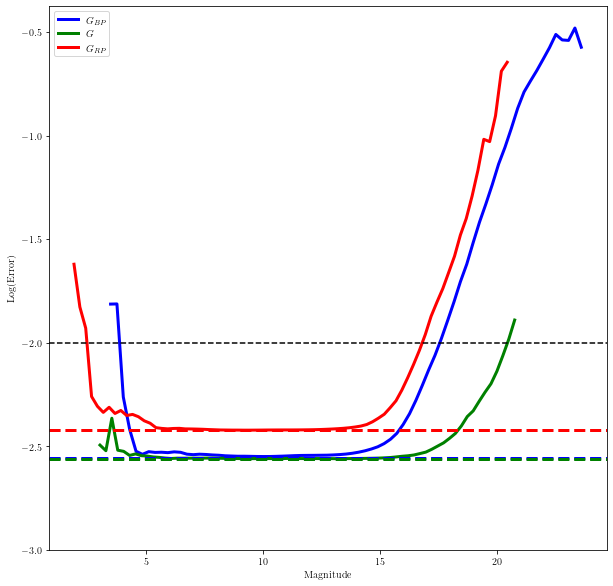

In [10]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Fit the errors
bp_fin = np.where(np.isfinite(bpbin)==True)
g_fin = np.where(np.isfinite(gbin)==True)
rp_fin = np.where(np.isfinite(rpbin)==True)

bperrfunc = bspline(np.arange(bpmin,bpmax,bpdiff/binnum)[bp_fin],bpbin[bp_fin])
gerrfunc = bspline(np.arange(gmin,gmax,gdiff/binnum)[g_fin],gbin[g_fin])
rperrfunc = bspline(np.arange(rpmin,rpmax,rpdiff/binnum)[rp_fin],rpbin[rp_fin])

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.axhline(np.log10(0.0027901700),lw=3.0,c='blue',ls='--')
plt.axhline(np.log10(0.0027553202),lw=3.0,c='green',ls='--')
plt.axhline(np.log10(0.0037793818),lw=3.0,c='red',ls='--')
plt.axhline(np.log10(0.01),c='k',ls='--')
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');
# plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

<ipython-input-11-07e5540357a3>:27: RuntimeWarning: divide by zero encountered in log10
  hmaherr = np.log10(allStar['H_ERR'][h_fin])


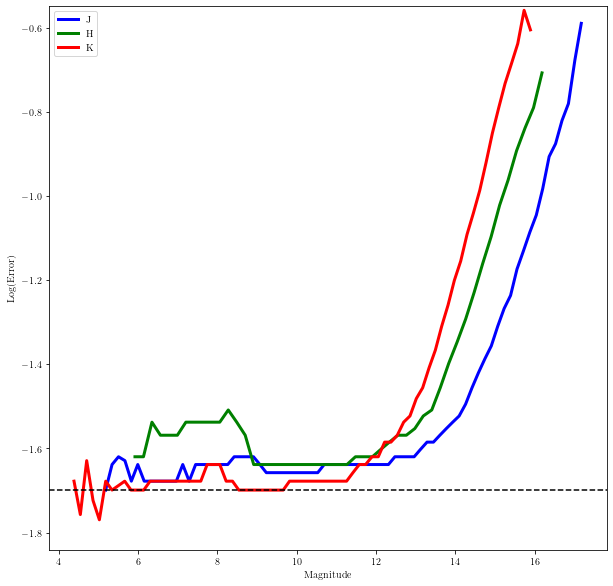

In [11]:
allStar = Table(fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz'))
allStar = allStar['APOGEE_ID','FE_H','FE_H_ERR','J','H','K','J_ERR','H_ERR','K_ERR']

binnum = 75

### J
j_fin = np.where((np.isfinite(allStar['J'])==True)&(allStar['J']<50.)&
                 (np.isfinite(allStar['J_ERR'])==True)&(allStar['J_ERR']<1.))

jmin = min(allStar['J'][j_fin])
jmax = max(allStar['J'][j_fin])

jdiff = jmax-jmin
jmaherr = np.log10(allStar['J_ERR'][j_fin])

jbin ,_,_ = binned_statistic(allStar['J'][j_fin],jmaherr,'median',bins=binnum)
jerrfunc = bspline(np.arange(jmin,jmax,jdiff/binnum),jbin)

### H
h_fin = np.where((np.isfinite(allStar['H'])==True)&(allStar['H']<50.)&
                 (np.isfinite(allStar['H_ERR'])==True)&(allStar['H_ERR']<1.))

hmin = min(allStar['H'][h_fin])
hmax = max(allStar['H'][h_fin])

hdiff = hmax-hmin
hmaherr = np.log10(allStar['H_ERR'][h_fin])

hbin ,_,_ = binned_statistic(allStar['H'][h_fin],hmaherr,'median',bins=binnum)
herrfunc = bspline(np.arange(hmin,hmax,hdiff/binnum),hbin)

### K
k_fin = np.where((np.isfinite(allStar['K'])==True)&(allStar['K']<50.)&
                 (np.isfinite(allStar['K_ERR'])==True)&(allStar['K_ERR']<1.))

kmin = min(allStar['K'][k_fin])
kmax = max(allStar['K'][k_fin])

kdiff = kmax-kmin
kmaherr = np.log10(allStar['K_ERR'][k_fin])

kbin ,_,_ = binned_statistic(allStar['K'][k_fin],kmaherr,'median',bins=binnum)
kerrfunc = bspline(np.arange(kmin,kmax,kdiff/binnum),kbin)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(jmin,jmax,jdiff/binnum),jbin,lw=3.0,c='blue',label=r'J')
plt.plot(np.arange(hmin,hmax,hdiff/binnum),hbin,lw=3.0,c='green',label=r'H')
plt.plot(np.arange(kmin,kmax,kdiff/binnum),kbin,lw=3.0,c='red',label=r'K')
plt.legend()
plt.axhline(np.log10(0.02),c='k',ls='--')
plt.ylim(top=-0.55)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');
# plt.savefig('../plots/2masserrorcurve.pdf',dpi=300,bbox_inches='tight');

### Calculate Errors for NaNs
jerr = 999999.0*np.ones(len(lmcdr17))
herr = 999999.0*np.ones(len(lmcdr17))
kerr = 999999.0*np.ones(len(lmcdr17))

for i in range(len(lmcdr17)):
    if np.isfinite(lmcdr17['J_ERR'][i])==False:
        jerr[i] = 10**jerrfunc(lmcdr17['J'][i])
    else:
        jerr[i] = lmcdr17['J_ERR'][i]
        
    if np.isfinite(lmcdr17['H_ERR'][i])==False:
        herr[i] = 10**herrfunc(lmcdr17['H'][i])
    else:
        herr[i] = lmcdr17['H_ERR'][i]
        
    if np.isfinite(lmcdr17['K_ERR'][i])==False:
        kerr[i] = 10**kerrfunc(lmcdr17['K'][i])
    else:
        kerr[i] = lmcdr17['K_ERR'][i]
        
### Replace nan's with zeropoint error
jerr = np.nan_to_num(jerr,nan=0.02)
herr = np.nan_to_num(herr,nan=0.02)
kerr = np.nan_to_num(kerr,nan=0.02)

In [13]:
from scipy.interpolate import BSpline


teff_tck = (np.array([3527.46704102, 3527.46704102, 3527.46704102, 3527.46704102, 3708.91847923, 3890.36991744, 
                      4071.82144442, 4253.27263849, 4434.72434304, 4616.17578125, 4797.62695312, 4979.07848011,
                      5160.53018466, 5341.98144531, 5523.43261719, 5523.43261719, 5523.43261719, 5523.43261719]),
            np.array([ -36.38271977,  -43.37201334,  -17.08585409,   67.8896712 , 69.84606503,  100.46933976,  
                      103.94758719,   75.90855137,60.21227975,   -5.14343676,   -6.42134699,  217.36965544,
                      -447.26168354, -197.7697192 ,    0.        ,    0.        , 0.        ,    0.        ]),3)


tcorr_spl = BSpline(teff_tck[0],teff_tck[1],teff_tck[2])

tcorr = tcorr_spl(lmcdr17['FPARAM'][:,0])+lmcdr17['FPARAM'][:,0]

mh_tck = (np.array([-2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -1.96716837e+00,
                    -1.71575650e+00, -1.46434463e+00, -1.21293276e+00, -9.61520889e-01, -7.10109077e-01,
                    -4.58697175e-01, -2.07285313e-01, 4.41265486e-02, 2.95538409e-01, 5.46950281e-01, 
                    5.46950281e-01, 5.46950281e-01, 5.46950281e-01]),
          np.array([1.12848696e+02, 1.00546777e+02, 1.15992357e+02, 9.79509398e+01, 3.87315323e+01, 
                    1.86357031e+01, -1.50821811e+01, 1.21509274e+01, 6.69424869e+00, -2.90025110e+00,
                    -2.68067104e+01, -3.13392475e+01, -8.25826363e+01,-6.49082047e+01, 0.00000000e+00, 
                    0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),3)

teff_cal = BSpline(mh_tck[0],mh_tck[1],mh_tck[2])(lmcdr17['FPARAM'][:,3])+tcorr

In [14]:
lmcdis

array([50.39704975, 50.45594422, 50.41259494, ..., 53.65900043,
       53.67466314, 53.60615884])

In [16]:
lmc_data = Table(lmcdr17)['TEFF','TEFF_ERR','LOGG','LOGG_ERR','FE_H','FE_H_ERR','GAIAEDR3_PHOT_BP_MEAN_MAG',
                          'GAIAEDR3_PHOT_G_MEAN_MAG','GAIAEDR3_PHOT_RP_MEAN_MAG','J','H','K']

lmc_data['GAIAEDR3_PHOT_G_MEAN_MAG'].name = 'G'
lmc_data['GAIAEDR3_PHOT_RP_MEAN_MAG'].name = 'RP'
lmc_data['GAIAEDR3_PHOT_BP_MEAN_MAG'].name = 'BP'

lmc_data['TEFF'] = teff_cal

lmc_data.add_column(apoafe, name='ALPHA_FE')
lmc_data.add_column(apoafe_err, name='ALPHA_FE_ERR')
lmc_data.add_column(lmcdis*1000, name='DISTANCE')

lmc_data.add_column(jerr, name='J_ERR')
lmc_data.add_column(herr, name='H_ERR')
lmc_data.add_column(kerr, name='K_ERR')

lmc_data.add_column(bperr, name='BP_ERR')
lmc_data.add_column(gerr, name='G_ERR')
lmc_data.add_column(rperr, name='RP_ERR')

In [18]:
# lite = np.arange(len(kasc_data))[::12]

lmc_ext = 999999.0*np.ones((len(lmc_data),6))
lmc_ext_err = 999999.0*np.ones((len(lmc_data),6))

lmc_age = 999999.0*np.ones(len(lmc_data))
lmc_age_err = 999999.0*np.ones(len(lmc_data))
lmc_chi = 999999.0*np.ones(len(lmc_data))
lmc_rms = 999999.0*np.ones(len(lmc_data))
lmc_d_int_IMF = 999999.0*np.ones(len(lmc_data))
lmc_mass = 999999.0*np.ones(len(lmc_data))
lmc_mass_err = 999999.0*np.ones(len(lmc_data))


for i in tqdm(range(len(lmc_data))):
    
    CalcAge = Aetas(lmc_data[i],massive,teff_extrap_limit=200)#,debug=True)
    
    # Run Extinctions
    lmc_ext[i,:],lmc_ext_err[i,:] = CalcAge.extinction()
    
    # get weighted age, age error, age chi, age RMS, delta int_IMF, mass, and mass error
    wgt_result = CalcAge.weighted_age_mass()
    lmc_age[i],lmc_age_err[i],lmc_chi[i],lmc_rms[i],lmc_d_int_IMF[i],lmc_mass[i],lmc_mass_err[i]=wgt_result

  0%|          | 0/6130 [00:00<?, ?it/s]

<ipython-input-1-bbe4f5dd7251>:538: RuntimeWarning: invalid value encountered in log10
  lgage = np.log10(age*10**9)


In [21]:
# parsec_age = 999999.0*np.ones(len(kdr17))

# def neighbors(data,value):
#     '''
#     Find values of two elements closest to the given value

#     Inputs:
#     ------
#         data: data to search through 
#         value: value of interest

#     Output:
#     ------
#         close1: closest value under the given value
#         close2: closest value over the given value
#     '''

#     data = np.asarray(data)
#     close1 = data[(np.abs(np.subtract(data,value))).argmin()]
#     data = data[np.where(data!=close1)]
#     close2 = data[(np.abs(np.subtract(data,value))).argmin()]

#     return close1,close2

# def mass_2_age_PARSEC(mass,salfeh,teff,isochrones):
#     '''
#     Inputs:
#     ------
#         mass: star mass in Msun
#         teff: teff
#         salfeh: Salaris corrected [Fe/H]
#         isochrones: table of PARSEC isochrones
    
#     Output:
#     ------
#         age: age in Gyr
#     '''
    
#     feh_lo,feh_hi = neighbors(isochrones['MH'],salfeh)
    
#     test = np.where((isochrones['logTe']<np.log10(teff+200.))&
#                                  (isochrones['logTe']>np.log10(teff-200.)))
    
# #     pdb.set_trace()
    
#     idx_lo = np.where((isochrones['MH']==feh_lo)&
#                                  (isochrones['logTe']<np.log10(teff+200.))&
#                                  (isochrones['logTe']>np.log10(teff-200.)))
    
#     iso_lo = isochrones[idx_lo]
    
#     idx_hi = np.where((isochrones['MH']==feh_hi)&
#                                  (isochrones['logTe']<np.log10(teff+200.))&
#                                  (isochrones['logTe']>np.log10(teff-200.)))
    
#     iso_hi = isochrones[idx_hi]
    
#     try:
#         # lower [Fe/H]
#         sidx_lo = np.argsort(iso_lo['Mass'])
#         smass_lo = iso_lo['Mass'][sidx_lo]
#         _,uidx_lo = np.unique(smass_lo,return_index=True)
#         smass_lo = smass_lo[uidx_lo]
#         sage_lo = 10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9

#         spl_lo = interp1d(smass_lo,sage_lo)

#         # higher [Fe/H]
#         sidx_hi = np.argsort(iso_hi['Mass'])
#         smass_hi = iso_hi['Mass'][sidx_hi]
#         _,uidx_hi = np.unique(smass_hi,return_index=True)
#         smass_hi = smass_hi[uidx_hi]
#         sage_hi = 10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9

#         spl_hi = interp1d(smass_hi,sage_hi)

#         # final spline
#         final_spl = interp1d([feh_lo,feh_hi],[spl_lo(mass),spl_hi(mass)])
#         age = final_spl(salfeh)
#         return age
#     except:
#         return 999999.0

# for i in tqdm(range(len(kdr17))):
#     parsec_age[i] = mass_2_age_PARSEC(k674['APOKASC3P_MASS'][i],salfeh[i],teff_cal[i],
#                                       massive[np.where(massive['label']==3)])

  0%|          | 0/6099 [00:00<?, ?it/s]

In [20]:
# len(lmc_age)

6130

In [21]:
from astropy.table import Table, Column

cname = Column(lmcdr17['APOGEE_ID'], name='NAME')#

cext = Column(lmc_ext,name='EXT')#
cext_err = Column(lmc_ext_err,name='EXT_ERR')#

cage = Column(lmc_age,name='AGE')#
cage_err = Column(lmc_age_err,name='AGE_ERR')#
cchi = Column(lmc_chi,name='AGE_CHI')#
crms = Column(lmc_rms,name='AGE_RMSE')#

cmass = Column(lmc_mass,name='MASS')#
cmass_err = Column(lmc_mass,name='MASS_ERR')#

cd_int_IMF = Column(lmc_d_int_IMF,name='DELTA_INT_IMF')#

agetable = Table([cname,cext,cext_err,cage,cage_err,cchi,crms,cmass,cmass_err,cd_int_IMF])
agetable.write('lmc_lm_wgtage_07OCT2022.fits',format='fits', overwrite=True)

In [22]:
agetab = Table.read('lmc_lm_wgtage_07OCT2022.fits')

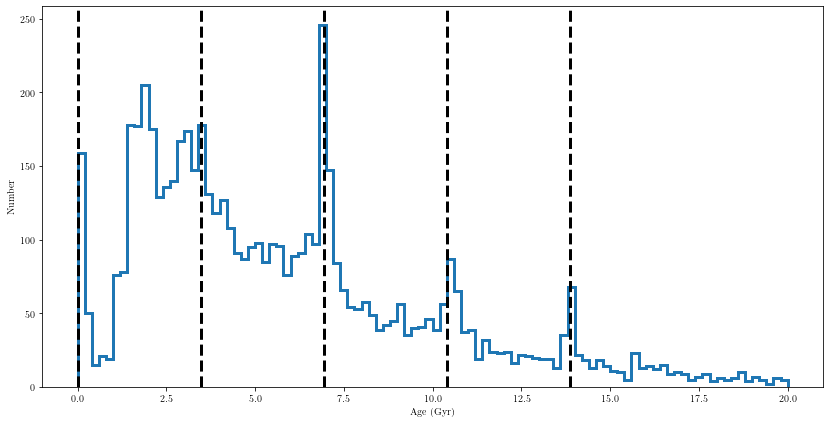

In [49]:
plt.figure(figsize=[14,7])
plt.hist(agetab['AGE'],histtype='step',range=(0,20),bins=100,lw=3.0)
for i in np.linspace(0.012,17.)[::10]:
    plt.axvline(i,c='k',ls='--',lw=3.0)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Number')
plt.savefig('lmc_age_histogram_wgtage.png',bbox_inches='tight')
plt.show()

# Investigatio in stellas iuvenes

In [47]:
# stars younger than the youngest isochrone 
np.where(agetab['AGE']<0.024)

(array([  71,  147,  293,  453,  520,  574,  588,  644,  682,  707,  725,
         747,  806,  900, 1020, 1137, 1696, 1725, 1761, 1768, 1812, 2109,
        2138, 2536, 2544, 2719, 2771, 2880, 2918, 2969, 3011, 3476, 3583,
        3612, 3674, 3739, 3760, 3830, 3859, 4013, 4043, 4097, 4315, 4381,
        4538, 4562, 4585, 4755, 4896, 4908, 4909, 4963, 5013, 5071, 5264,
        5425, 5695, 5791, 5796, 5828, 5967]),)

In [ ]:
peak7ish = np.where((agetab[]>)&())

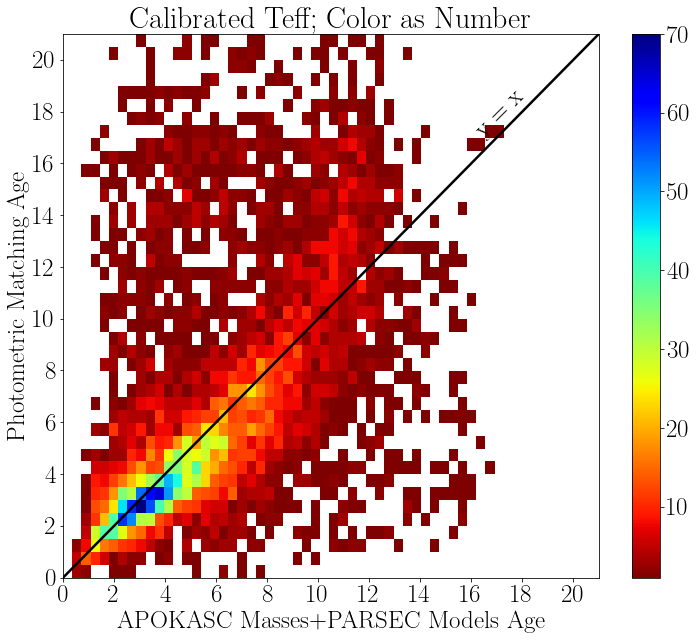

In [37]:
# plt.figure(figsize=[12,10])
# xmax = 18
# ymax = 25
# nbins = 50

# age2age_fincut = np.where((np.isfinite(agetab['AGE'])==True)&(agetab['AGE']<100.)&
#                          (np.isfinite(agetab['PARSEC_AGE'])==True)&
#                          (agetab['PARSEC_AGE']<100.))

# age2age_ret = binned_statistic_2d(agetab['PARSEC_AGE'],agetab['AGE'],
#                                   agetab['PARSEC_AGE'],'count',
#                                   bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/nbins)])

# age2age_ret.statistic[age2age_ret.statistic == 0.0] = np.nan

# im = plt.imshow(age2age_ret.statistic.T, origin='lower',
#                 extent=[age2age_ret.x_edge[0],age2age_ret.x_edge[-1],
#                         age2age_ret.y_edge[0],age2age_ret.y_edge[-1]],
#                 aspect='auto',interpolation='nearest',cmap='jet_r')

# plt.colorbar()

# plt.plot([0,21],[0,21],lw=2.5,c='k')
# # plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
# # plt.plot([0,17.25],[4,17.25+4],lw=2.5,c='k')
# # plt.plot([0,10.95],[11,11],lw=2.5,c='k')

# # plt.plot([11,11],[0,5.5],c='k',lw=2.5)
# # plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

# xshift = 10
# yshift = 10
# plt.text(6+xshift,7+yshift,'y = x',rotation=45)
# # plt.text(8+xshift,4.8+yshift,'y = x - 4',rotation=45)
# # plt.text(4+xshift,8.8+yshift,'y = x + 4',rotation=45)
# # plt.text(0.75,11.3,'y = 11')


# plt.xlim(0,21)
# plt.ylim(0,21)

# plt.xticks(np.arange(0,21)[::2],np.arange(0,21)[::2].astype('str'))
# plt.yticks(np.arange(0,21)[::2],np.arange(0,21)[::2].astype('str'))

# plt.title(r'Calibrated Teff; Color as Number')
# plt.xlabel(r'APOKASC Masses+PARSEC Models Age')
# plt.ylabel(r'Photometric Matching Age')

# plt.savefig('kasc_age2age_wgtage_speed.png',bbox_inches='tight')
# plt.show()

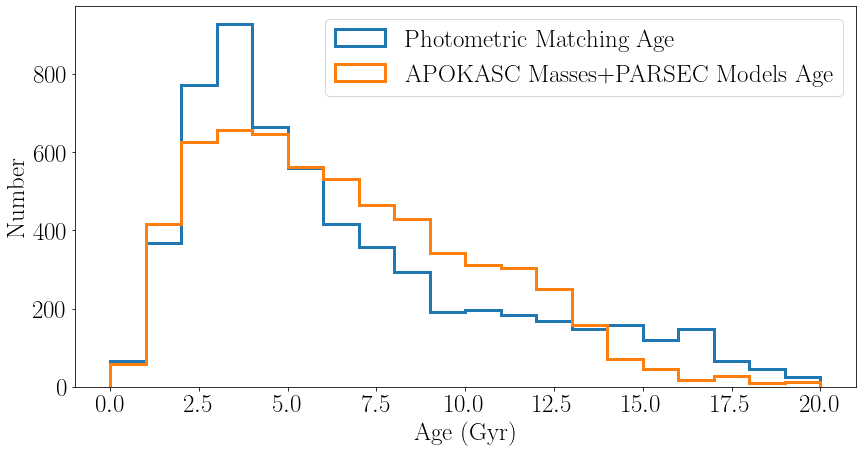

In [40]:
# plt.figure(figsize=[14,7])
# plt.hist(agetab['AGE'],histtype='step',range=(0,20),bins=20,lw=3.0,label='Photometric Matching Age')
# plt.hist(k674['A3P_AGEMOD_JT'],histtype='step',range=(0,20),bins=20,lw=3.0,label='APOKASC Masses+PARSEC Models Age')
# plt.legend()
# plt.xlabel(r'Age (Gyr)')
# plt.ylabel(r'Number')
# plt.savefig('apokasc_age_histogram.png',bbox_inches='tight')
# plt.show()